In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from tools.getNBA_data_webscraping import getData
from tools.getNBA_data_api import get_df_with_api
from sklearn.decomposition import PCA
import numpy as np 

### Notebook outline
1. Objectives
    - Predicting the number of wins an NBA team will achieve  
    - Features: <br>
        - GP - Gamee Played
        - W - Wins
        - L - Losses
        - WIN% - Win Percentage
        - Min - Minutes Played
        - PTS Points
        - FGM - Field Goals Made
        - FGA - Field Goals Attempted
        - FG% - Field Goal Percentage
        - 3PM - 3 Point Field Goals Made
        - 3PA - 3 Point Field Goals Attempted
        - 3P% - 3 Point Field Goal Percentage
        - FTM - Free Throws Made
        - FTA - Free Throws Attempted
        - FT% - Free Throw Percentage
        - OREB - Offensive Rebounds
        - DREB - Defensive Rebounds
        - REB - Rebounds
        - AST - Assists
        - TOV - Turnovers
        - STL - Steals
        - BLK - Blocks
        - BLKA - Blocks Against
        - PF - Personal Fouls
        - PFD - Personal Fouls Drawn
        - +/- - Plus-Minus
    - Model: Linear Regression
2. Get data through web scraping
    - Season=2023-24: Training set
    - Season=2024-25: Test set
3. Data Exploring (Exploratory Data Analysis) 
    - Check features' distribution 
    - Use charts to visulize the relationship between features and the dependent variable 
    - Heatmap matrix to find the correlation between features 
4. Data processing
    - Delete variables with high correlations (>0.8)
    - Dimensionality Reduction using PCA
    - PCA Loadings (factor loadings or PCA loadings) 
5. Data preparation 
6. Data modelling
7. Evaluate model on training set
    - Check MAE, MSE, RMSE, R2 
	- Use statsmodels to validate statistical hypotheses
	- Visulization
8. Evaluate model on test data 
    - Check MAE, MSE, RMSE, R2 
	- Use statsmodels to validate statistical hypotheses
	- Visulization
9. Conclusions
    - The true causal effect of the features on the dependent variable
    - Compare MAE, MSE, RMSE, R2 on train & test data
    - Conclustion 

### 2. Get data through web scraping

In [17]:
df = getData('2023-24') # web scraping
df_test = getData('2024-25')  

df.head()

,TEAM,GP,W,L,WIN%,MIN,PTS,FGM,FGA,FG%,...,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,+/-
0,Atlanta Hawks,82,36,46,.439,48.4,118.3,43.0,92.5,46.5,...,32.2,44.7,26.6,13.5,7.5,4.5,5.6,18.6,19.4,-2.2
1,Boston Celtics,82,64,18,.780,48.4,120.6,43.9,90.2,48.7,...,35.6,46.3,26.9,11.9,6.8,6.6,3.7,16.2,17.3,11.3
2,Brooklyn Nets,82,32,50,.390,48.3,110.4,40.7,89.1,45.6,...,32.6,44.1,25.6,13.1,6.8,5.2,5.0,18.5,18.2,-2.9
3,Charlotte Hornets,82,21,61,.256,48.1,106.6,40.0,87.0,46.0,...,31.0,40.3,24.8,13.8,6.9,4.5,4.8,18.0,17.5,-10.2
4,Chicago Bulls,82,39,43,.476,48.7,112.3,42.0,89.5,47.0,...,32.6,43.8,25.0,12.2,7.8,4.8,4.9,18.8,18.8,-1.4


### 3. Data Exploring (Exploratory Data Analysis) 

In [18]:
df.columns

Index(['TEAM', 'GP', 'W', 'L', 'WIN%', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%',
       '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST',
       'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', '+/-'],
      dtype='object')

Drop percentage columns

In [19]:
df_team = df["TEAM"]
df = df.drop(['TEAM', 'GP', 'L', 'WIN%','MIN', 'FG%','3P%','FT%', '+/-'], axis=1) 
df = df.astype(float)
cols = df.columns
df.describe()

,W,PTS,FGM,FGA,3PM,3PA,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,41.000000,114.220000,42.176667,88.903333,12.840000,35.106667,17.026667,21.723333,10.543333,32.986667,43.546667,26.673333,13.596667,7.476667,5.146667,5.133333,18.733333,18.726667
std,13.411266,4.254847,1.717995,2.073558,1.217572,2.880605,1.368849,1.504174,1.153311,1.240337,1.459507,1.854711,1.060411,0.555029,0.794695,0.735003,1.308944,0.854979
min,14.000000,105.800000,38.400000,84.900000,11.000000,31.200000,14.500000,18.400000,8.200000,30.100000,40.300000,23.100000,11.900000,6.500000,3.400000,3.700000,15.600000,17.300000
25%,31.250000,112.150000,41.300000,87.425000,12.100000,32.800000,15.850000,20.500000,9.725000,31.975000,42.700000,25.125000,12.750000,7.025000,4.600000,4.625000,18.050000,18.025000
50%,46.500000,114.450000,42.150000,89.200000,12.600000,34.750000,17.000000,21.650000,10.500000,33.100000,43.450000,26.600000,13.350000,7.500000,5.000000,5.000000,18.600000,18.700000
75%,49.000000,117.500000,43.100000,90.125000,13.300000,36.775000,18.250000,22.875000,11.150000,33.850000,44.200000,27.975000,14.275000,7.800000,5.825000,5.750000,19.650000,19.200000
max,64.000000,123.300000,47.000000,92.700000,16.500000,42.500000,19.500000,24.400000,12.700000,35.600000,46.700000,30.800000,15.700000,8.500000,6.600000,6.500000,21.400000,20.900000


### 3.1 Check features' distribution 

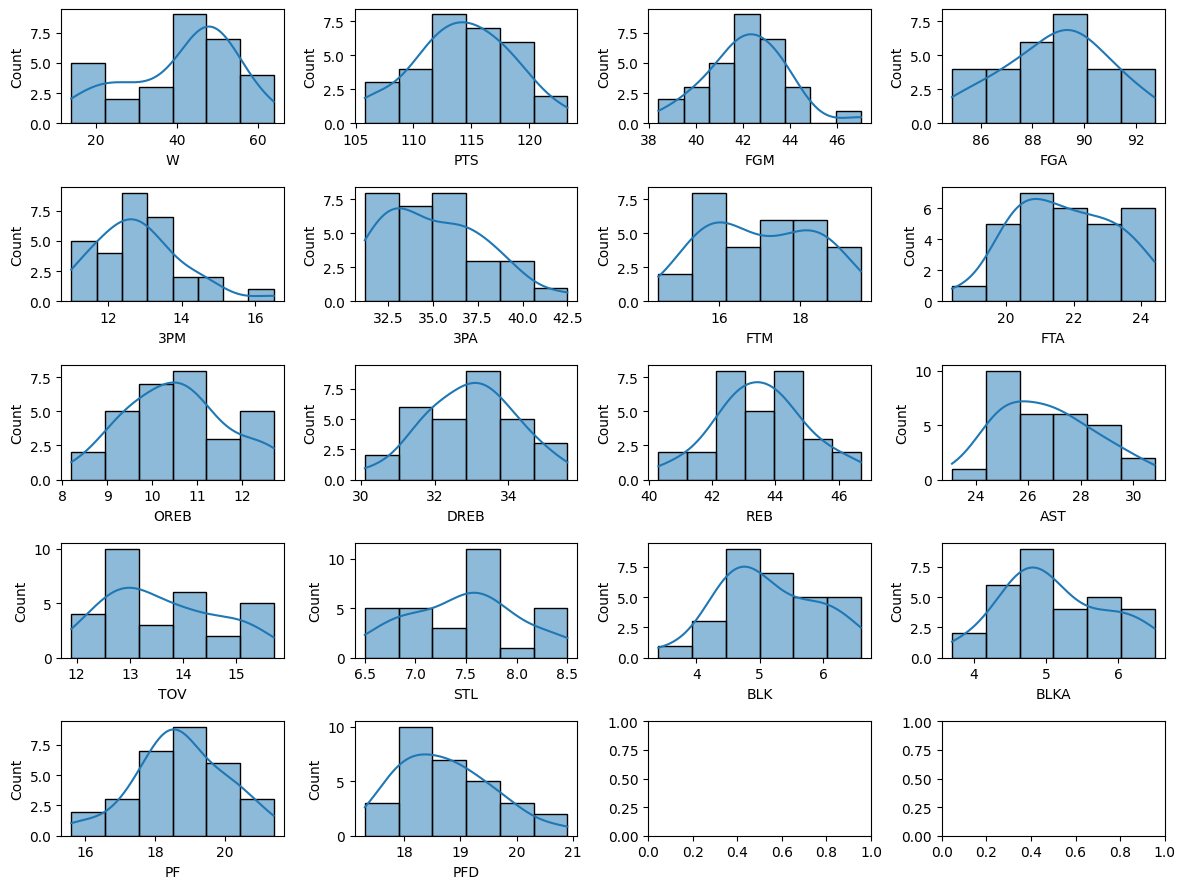

In [20]:
def plotHist(dataFrame, colNum = 4, figsize=(12, 9)):
    rowNum = (len(dataFrame.columns) + colNum - 1 ) // colNum

    _, ax = plt.subplots(rowNum, colNum, figsize = figsize)
    ax = ax.flatten()

    for i, col in enumerate(dataFrame.columns): 
        sns.histplot(data=dataFrame, x=col, ax=ax[i], kde=True)
    plt.tight_layout()
    plt.show()

plotHist(df)

### 3.2 Use charts to visulize the relationship between features and the dependent variable 

In [21]:
cols[1:]

Index(['PTS', 'FGM', 'FGA', '3PM', '3PA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB',
       'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD'],
      dtype='object')

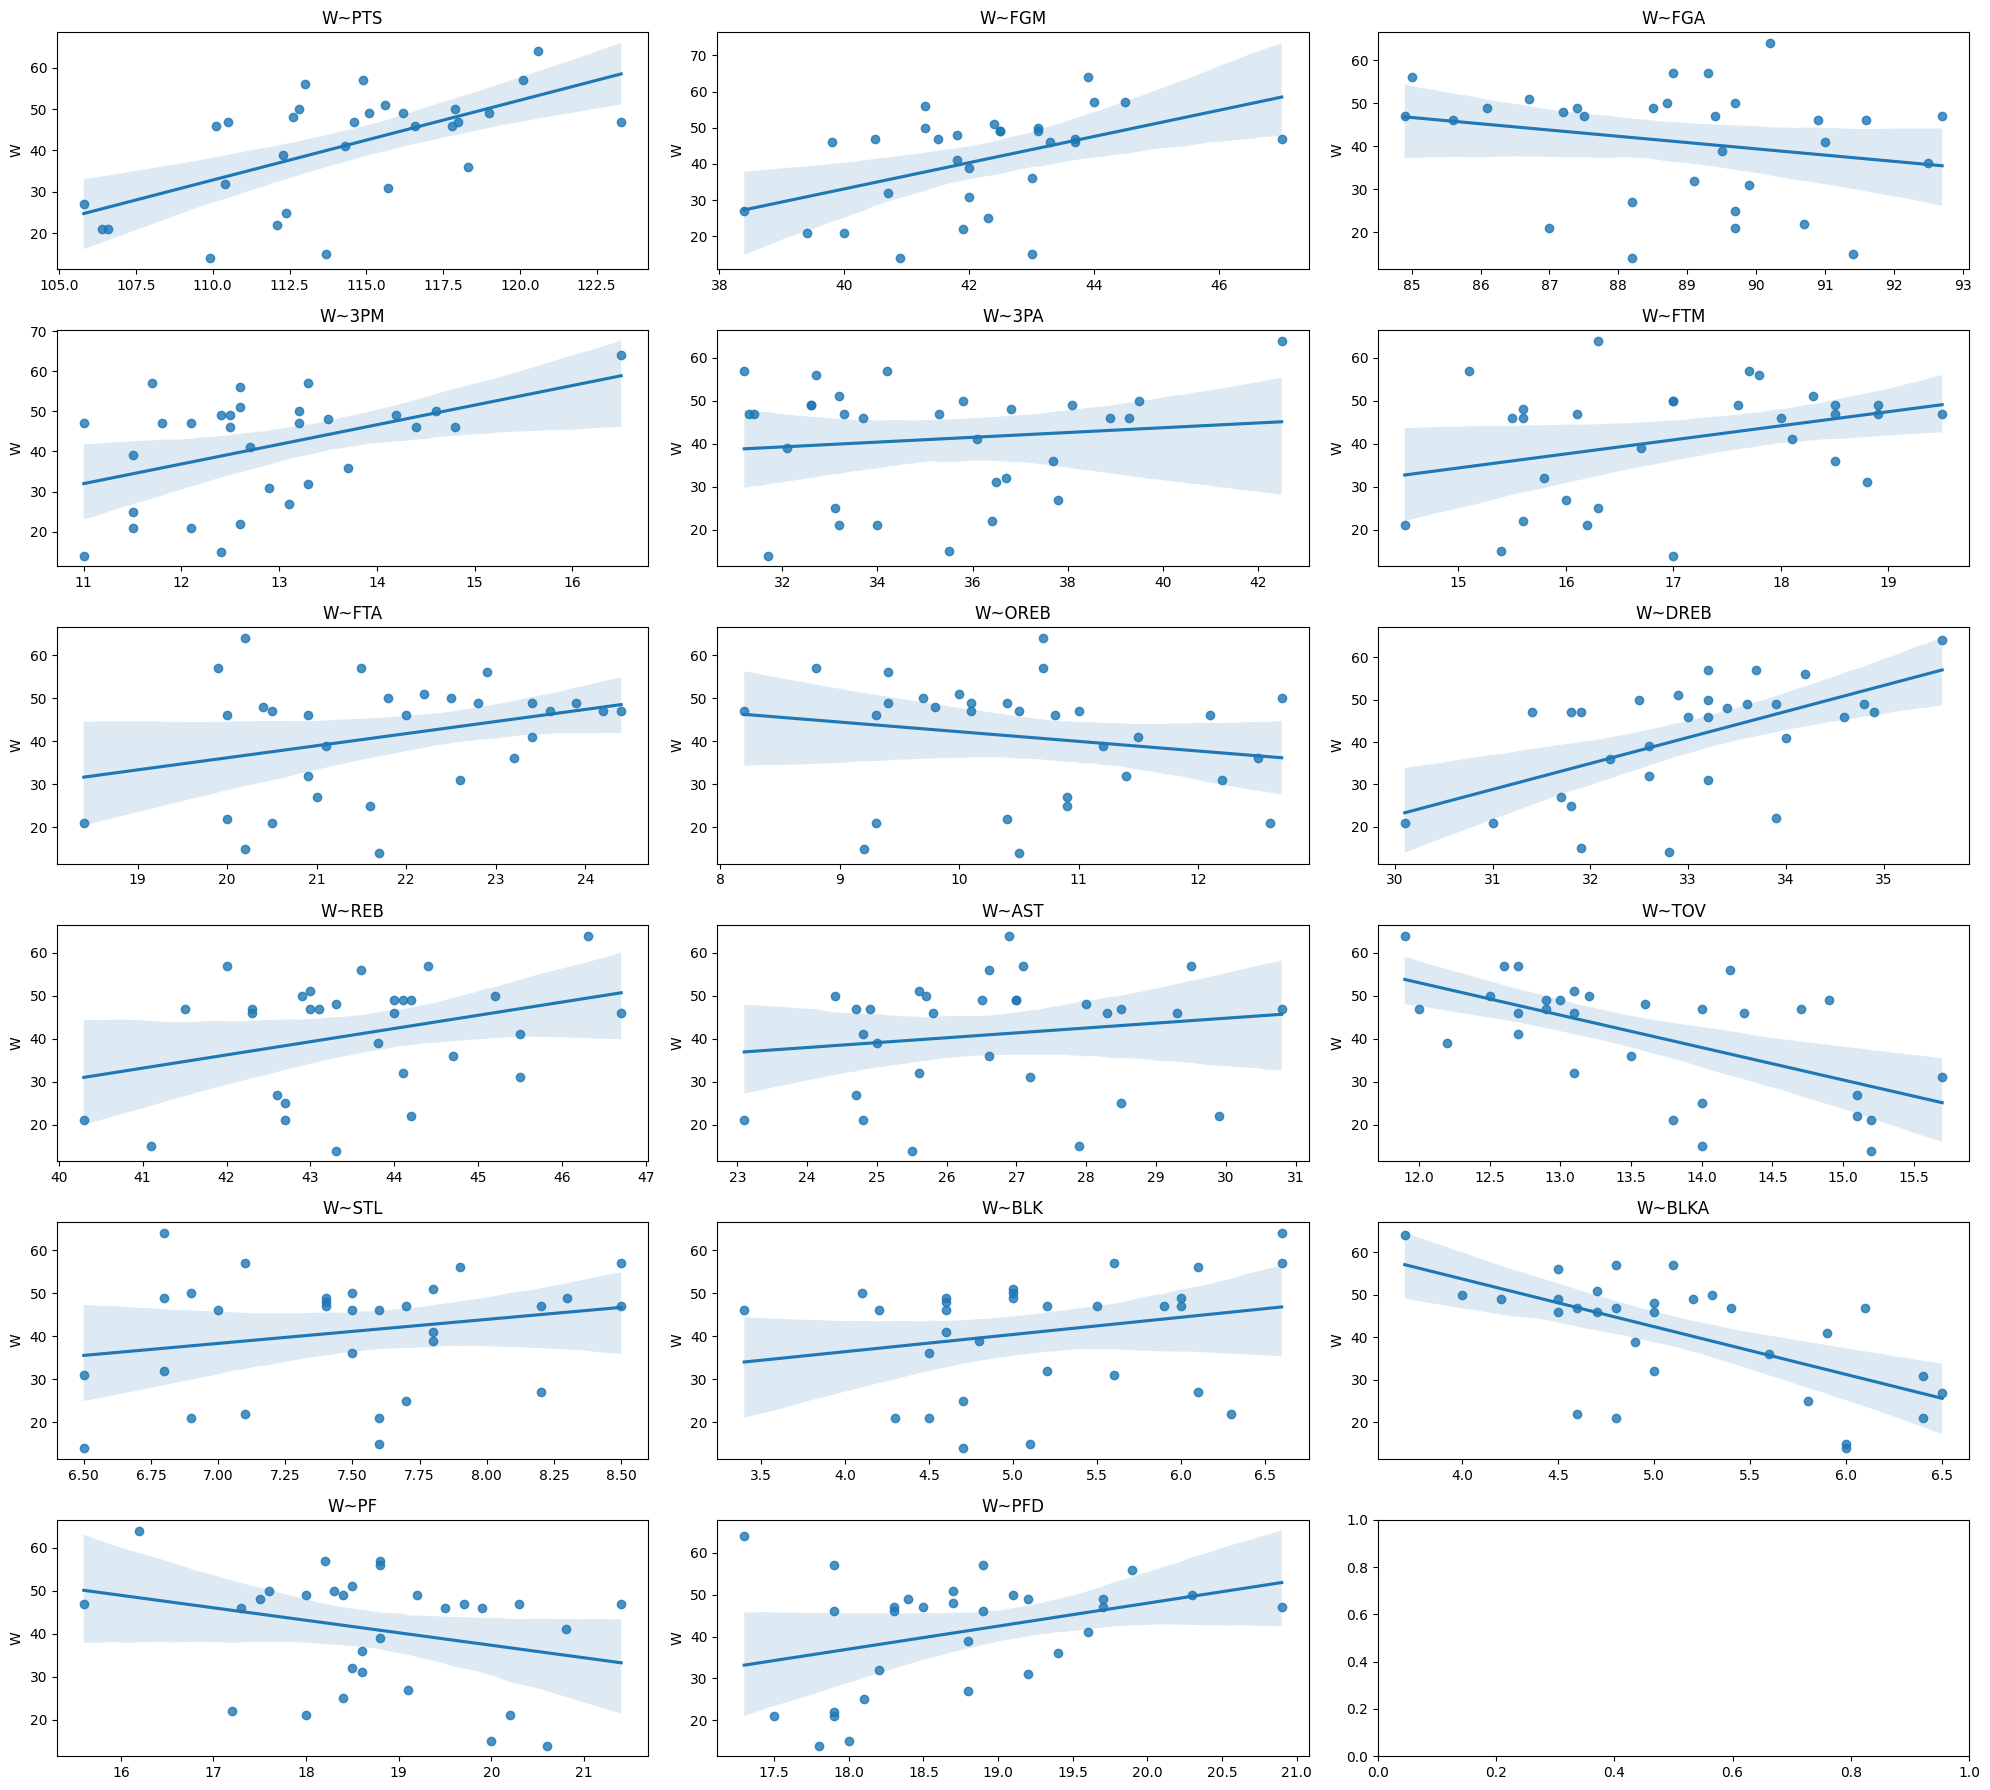

In [22]:
fig, axes = plt.subplots(6,3,figsize=(20, 18))
axes = axes.flatten()

for i, col in enumerate(cols[1:]):
    sns.regplot(data=df, x=col, y='W',ax=axes[i])
    axes[i].set_title(f"W~{col}")
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

### 3.3 Heatmap matrix to find the correlation between features 

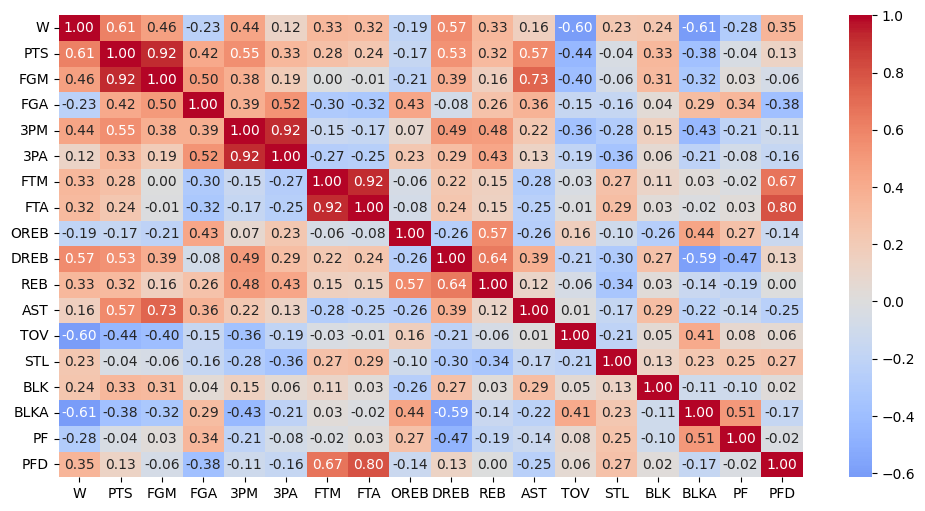

In [23]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.2f', center=0)
plt.show()

### 4. Data processing


4.1. Delete features with high correlations (>0.8)

In [24]:
corr_matrix = df.corr()
filtered_matrix = corr_matrix[abs(corr_matrix) > 0.8]
pairs = filtered_matrix.unstack().dropna()
pairs = pairs[pairs != 1]  # Loại bỏ các cặp có tương quan bằng 1 (tương quan với chính nó)

colums_to_delete = set()
for i, pair in enumerate(pairs):
    col1 = pairs.index[i][0]
    col2 = pairs.index[i][1]
    colums_to_delete.add(col1 if df[col1].var() < df[col2].var() else col2) # keep column with a higher variance 

print(colums_to_delete)


{'3PM', 'FGM', 'FTM'}


In [25]:
df = df.drop(columns=colums_to_delete).reset_index(drop=True)
df.head()

,W,PTS,FGA,3PA,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD
0,36.0,118.3,92.5,37.7,23.2,12.5,32.2,44.7,26.6,13.5,7.5,4.5,5.6,18.6,19.4
1,64.0,120.6,90.2,42.5,20.2,10.7,35.6,46.3,26.9,11.9,6.8,6.6,3.7,16.2,17.3
2,32.0,110.4,89.1,36.7,20.9,11.4,32.6,44.1,25.6,13.1,6.8,5.2,5.0,18.5,18.2
3,21.0,106.6,87.0,34.0,18.4,9.3,31.0,40.3,24.8,13.8,6.9,4.5,4.8,18.0,17.5
4,39.0,112.3,89.5,32.1,21.1,11.2,32.6,43.8,25.0,12.2,7.8,4.8,4.9,18.8,18.8


### 4.2 Dimensionality Reduction using PCA

In [26]:
X = df.iloc[:, 1:]

pca = PCA().fit(X)
csum = np.cumsum(pca.explained_variance_ratio_)
k = len(csum[csum < 0.91]) # n_comp with ≥ 90–95% cumulative variance

pca = PCA(n_components=k).fit(X) 

### 4.3 PCA Loadings (factor loadings or PCA loadings) 
How much each original feature contributes to each Principal Component (PC).

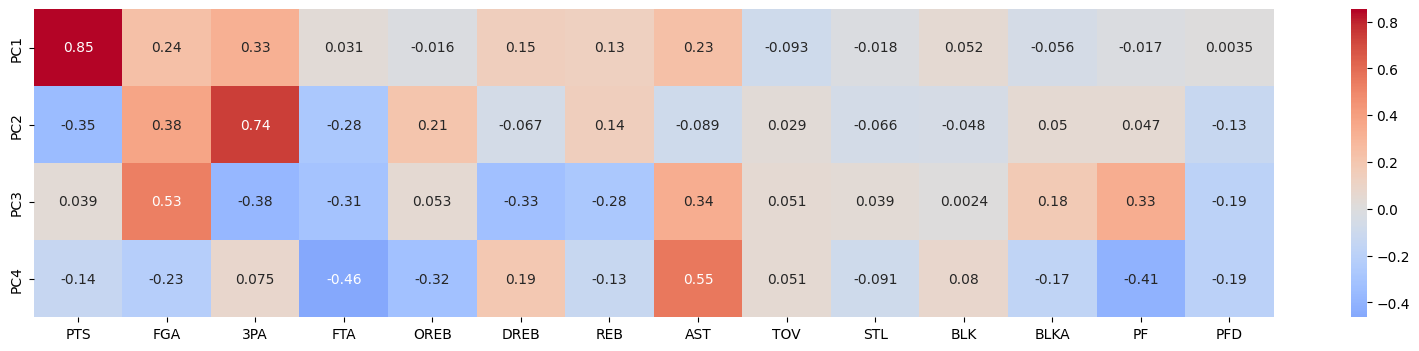

In [27]:
loadings_df = pd.DataFrame(
    pca.components_,
    columns=X.columns,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

#loadings_df
plt.figure( figsize=(20,4))
sns.heatmap(data=loadings_df, annot=True, cmap='coolwarm', center = 0) # center = 0 de ve color with 0 la giua cua khung mau
plt.show()

### 5. Data preparation 

In [28]:
df_test = df_test[df.columns].astype(float)
X_test = df_test[X.columns]
X_columns = X.columns

Transform X, X_test with PCA

In [29]:
X_reduced = pca.transform(X)
X_test_reduced = pca.transform(X_test)

y = df.iloc[:, 0]
y_test = df_test.iloc[:, 0]

### 6. Data modelling

In [30]:
model = LinearRegression()
model.fit(X_reduced,y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### 7. Evaluate model in training set

In [31]:
y_pred = model.predict(X_reduced)

### 7.1 Check MAE, MSE, RMSE, R2 

In [32]:
def printModelEval(y_true, y_p): 
    mae = mean_absolute_error(y_true, y_p)
    mse = mean_squared_error(y_true, y_p)
    rmse = root_mean_squared_error(y_true, y_p)
    r2 = r2_score(y_true, y_p)

    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R2 Score: {r2}")

    return (mae,mse, rmse, r2)

mae, mse, rmse, r2 = printModelEval(y,y_pred)

Mean Absolute Error: 6.562164100828661
Root Mean Squared Error: 61.45336242670918
Root Mean Squared Error: 7.839219503669302
R2 Score: 0.6465489124230683


### 7.2 Use statsmodels to validate statistical hypotheses.
[Interpreting linear regression summary from statsmodels](https://www.adrian.idv.hk/2021-07-16-statsmodels/#:~:text=t%3A%20Coef%20divided%20by%20Std%20Err%2C%20i.e.%2C%20the,its%20magnitude%20is%20large%20with%20small%20standard%20error)


1. Check P-values of each feature (coef p-value)
    - p < 0.05 → the variable is significant
    - p ≥ 0.05 → the variable is not significant and may be removed <br>
    => Feature X4 has p-value = 0.991, which is greater than 0.05 (5%) -> this feature has no effect on the depedent value => can be removed 
2.  Significance F-test (F-statistic & Prob (F-statistic)): Evaluate whether the overall model is statistically significant.
    - Prob(F-statistic) =  2.05e-05 < 0.05 → The model is statistically significant.
3. R-squared và Adj. R-squared:
    - R-squared: 0.647 (proportion of variance explained by the model)
    - Adj. R-squared: 0.590 (penalizes unnecessary variables)
4. Std Err & Confidence Interval (95% CI)
5. Durbin–Watson statistic: Checks autocorrelation of residuals
    - ~2 → no autocorrelation (good)
    - close to 0 → positive autocorrelation (problem)
    - close to 4 → negative autocorrelation (problem)
6. Cond. No (Condition Number): Checks for multicollinearity (correlated predictors):
    - < 30 → safe
    - 30 → possible collinearity
    - 100 → severe multicollinearity
7. Jarque-Bera & Omnibus tests: Tests whether residuals follow a normal distribution:
    - p > 0.05 → residuals are normally distributed (good)
    - p < 0.05 → residuals deviate from normality (a violation of OLS assumptions)

In [33]:
def genStatsModels(y_true, X): 
    X2 = sm.add_constant(X)
    model_states  = sm.OLS(y_true, X2)
    result = model_states.fit()
    print(result.summary())

genStatsModels(y, X_reduced)

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     11.43
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           2.05e-05
Time:                        16:18:29   Log-Likelihood:                -104.34
No. Observations:                  30   AIC:                             218.7
Df Residuals:                      25   BIC:                             225.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.0000      1.568     26.151      0.0

7.3 Visualization 

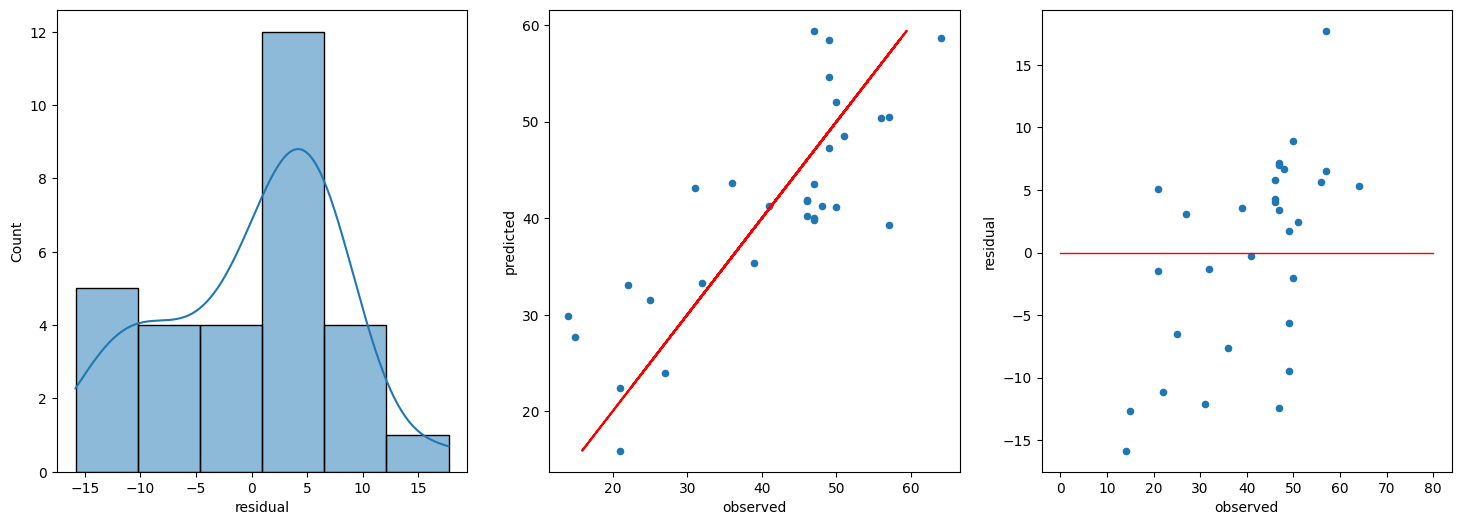

In [34]:
def plotResidualsPlot(y_true, y_p): 
    df_r = pd.concat([df_team, y, pd.Series(y_p), pd.Series(y_true -y_p)], axis=1)
    df_r.columns = ['Team', 'observed', 'predicted', 'residual']

    _, ax = plt.subplots(1,3, figsize=(18,6))

    sns.histplot(data=df_r,x='residual', ax=ax[0], kde=True) # bins is automatically calculated with Sturge’s Rule K = 1 + 3.322 * log(N) = 1 + 3.322 * log(30) => 6 

    df_r.plot.scatter(x='observed', y='predicted', ax=ax[1])
    ax[1].plot(df_r['predicted'], df_r['predicted'], color='red')
    
    df_r.plot.scatter(x='observed', y='residual', ax=ax[2])
    ax[2].plot([0,80],[0,0], color='red', linewidth=1)
    plt.show()

    return df_r

df_residuals = plotResidualsPlot(y, y_pred)

In [35]:
df_residuals

,Team,observed,predicted,residual
0,Atlanta Hawks,36.0,43.631530,-7.631530
1,Boston Celtics,64.0,58.649716,5.350284
2,Brooklyn Nets,32.0,33.317603,-1.317603
3,Charlotte Hornets,21.0,22.441432,-1.441432
4,Chicago Bulls,39.0,35.405464,3.594536
5,Cleveland Cavaliers,48.0,41.315095,6.684905
6,Dallas Mavericks,50.0,52.029169,-2.029169
7,Denver Nuggets,57.0,39.270886,17.729114
8,Detroit Pistons,14.0,29.840698,-15.840698
9,Golden State Warriors,46.0,41.735431,4.264569


The residuals are expected to have a mean of 0 because of the model’s assumptions

In [36]:
df_residuals.describe().round(2) #

,observed,predicted,residual
count,30.00,30.00,30.00
mean,41.00,41.00,-0.00
std,13.41,10.78,7.97
min,14.00,15.91,-15.84
25%,31.25,33.84,-6.28
50%,46.50,41.30,2.76
75%,49.00,48.22,5.54
max,64.00,59.42,17.73


### 8. Evaluate model on test set 

In [37]:
y_test.describe()

count    30.000000
mean     41.000000
std      13.354581
min      17.000000
25%      34.500000
50%      40.500000
75%      50.000000
max      68.000000
Name: W, dtype: float64

In [38]:
y_test_pred = model.predict(X_test_reduced)
y_test_pred

array([43.03974961, 49.04581604, 22.41756204, 22.98838603, 44.62967377,
       56.51812775, 46.66557244, 54.5285998 , 41.35135677, 38.20155939,
       38.12875885, 44.423505  , 44.32081487, 50.29440046, 49.66417626,
       40.21902721, 56.66460588, 46.86512255, 28.60601336, 40.50467631,
       45.86482411, 30.36426804, 31.25246822, 44.57761955, 32.09407199,
       41.50311977, 39.54142412, 24.20815984, 39.48220716, 26.61854691])

8.1 Check MAE, MSE, RMSE, R2 

In [39]:
mae_test, mse_test, rmse_test, r2_test = printModelEval(y_test,y_test_pred)

Mean Absolute Error: 7.198898899068288
Root Mean Squared Error: 78.60739278470223
Root Mean Squared Error: 8.86608102741579
R2 Score: 0.544040645100335


8.2 Use statsmodels to validate statistical hypotheses

In [40]:
genStatsModels(y_test, X_test_reduced)

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     9.468
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           8.41e-05
Time:                        16:18:30   Log-Likelihood:                -105.98
No. Observations:                  30   AIC:                             222.0
Df Residuals:                      25   BIC:                             229.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.6746      2.135     19.052      0.0

8.3 Visulization

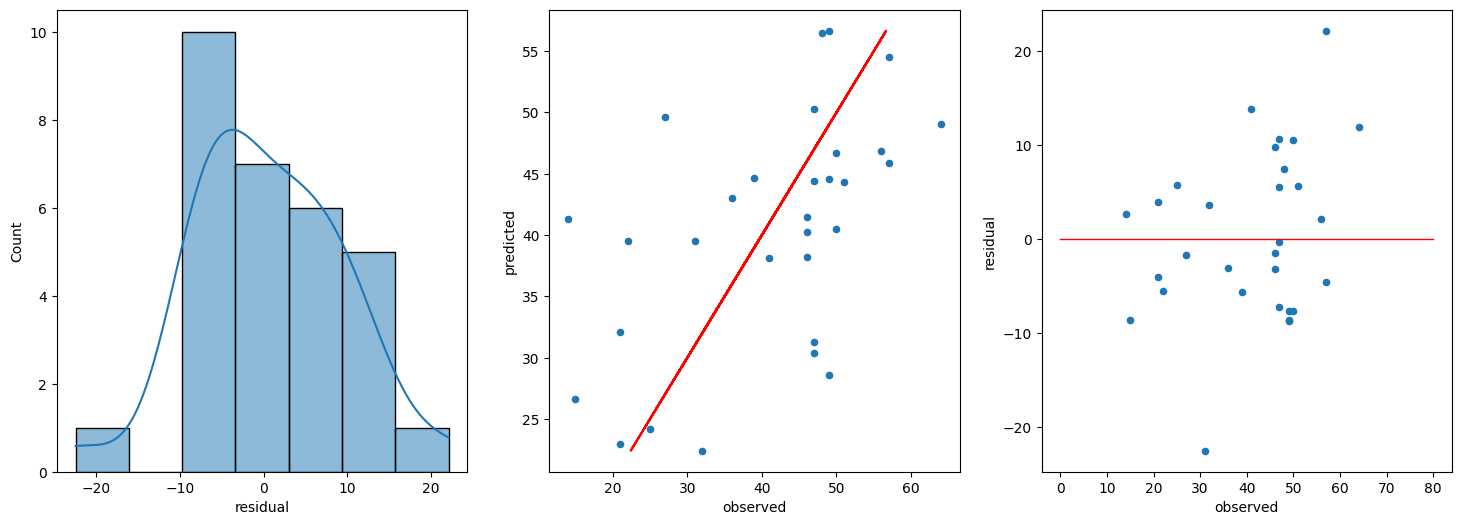

In [41]:
df_test_residuals = plotResidualsPlot(y_test,y_test_pred)

In [42]:
df_test_residuals.describe().round(2)

,observed,predicted,residual
count,30.00,30.00,30.00
mean,41.00,40.49,0.51
std,13.41,9.56,9.00
min,14.00,22.42,-22.48
25%,31.25,33.60,-5.61
50%,46.50,41.43,-0.90
75%,49.00,46.47,5.76
max,64.00,56.66,22.14


### 9. Conclusions/Implementation


9.1 The true causal effect of the features on the dependent variable

In [43]:
feature_impact = pca.components_.T @ model.coef_   # vector size n_features
impact_df = pd.DataFrame({"Impact_on_y": feature_impact}, index=X.columns).sort_values(by="Impact_on_y", ascending=False)
impact_df

,Impact_on_y
PTS,1.766052
FTA,1.429878
DREB,1.281331
PFD,0.770769
REB,0.757212
3PA,0.307577
BLK,0.152397
STL,-0.026312
TOV,-0.337878
AST,-0.484368


9.2 Compare MAE, MSE, RMSE, R2 on training & test set

Model seems to work better on test than training set

In [44]:
reports_data = {
    'DATA': ['Train data', 'Test data'],
    'MAE': [mae, mae_test],
    'MSE': [mse, mse_test], 
    'RMSE': [rmse, rmse_test], 
    'R2': [r2, r2_test]
}
reports_df = pd.DataFrame(reports_data)
reports_df

,DATA,MAE,MSE,RMSE,R2
0,Train data,6.562164,61.453362,7.839220,0.646549
1,Test data,7.198899,78.607393,8.866081,0.544041


9.3 Conclusion 

The model's predictability of the winning numbers of the next season's games is poor due to the small number of observations and the large number of different variables in relation to the number of observations.

MAE 7.20/(68-17) = 14.11 or 14.1%

R2 0.54404 on Test data, the model explains about 54% of the variation, meaning about half of it is excluded.

However, the model can be used to determine features that, based on the data, seem to affect winning.
Features that positively affect the win:
- PTS (Points)
- FTA (Free Throws Attempted)
- DREB (Offensive Rebounds)
- PFD (Personal Fouls Drawn), 
- REB (Rebounds)
- 3PA (3 Point Field Goals Attempted)
- BLK (Blocks) 


and negatively:
- FGA (Field Goals Attempted)
- PF (Personal Fouls)
- BLKA (Blocks Against)
- OREB (Offensive Rebounds)
- AST (Assists)
- TOV (Turnovers)
- STL: (Steals)

Missed field-goal attempts, Personal Fouls, Blocks Against, Offensive Rebounds worsen the result
